In [ ]:
!pip install ffmpeg-python
import pandas as pd 
import numpy as np 
import tensorflow as tf
import os,time,librosa,warnings,glob
import regex as re
from sklearn.metrics import confusion_matrix,classification_report
import librosa.display
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.layers import Dense,Input,Add,Flatten,Dropout,Activation,AveragePooling1D,Conv1D
from keras.models import Model,Sequential,load_model
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler,EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from google.colab.output import eval_js
from base64 import b64decode
from IPython.display import Audio,HTML
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg
warnings.filterwarnings("ignore")

In [ ]:
#decorator function for calculating the total time reqired to execute various function
def calc_time(func):
  def inner(*args, **kwargs):
    st = time.time()
    result = func(*args,**kwargs)
    end = time.time()-st
    print("Total time required: {:.3f} ms".format(end * 1000))
    return result
  return inner

#function for getting ravdess dataset details and labeling
def ravdess_data():
  #directory of the audio dataset
  ravdess = "/content/drive/MyDrive/Audiofiles/audio_speech_actors_01-24/"
  #label ravdess data
  emotion_ravdess = {'01':'neutral','02':'calm','03':'happy','04':'sad','05':'angry','06':'fearful','07':'disgust','08':'surprised'}
  #list to store ravdess emotion
  ravdess_emotion = []
  #list to store ravdess audio path
  ravdess_path = []
  #get subfolders from the path
  ravdess_folder = os.listdir(ravdess)
  for i in ravdess_folder:
    inner_files = os.listdir(ravdess+i+'/')
    for j in inner_files:
      #get the split part which contains the emotion information then append it into lists
      emotion = j.split('-')[2]
      ravdess_path.append(ravdess+i+'/'+j)
      ravdess_emotion.append(emotion_ravdess[emotion])

  #convert to dataframe
  df_ravdess = pd.DataFrame([ravdess_path,ravdess_emotion]).T
  df_ravdess.columns = ["AudioPath","Label"]
  print("length of ravdess dataset",len(df_ravdess))

  return df_ravdess

#function for getting crema dataset details and labeling
def crema_data():
  #directory of the audio dataset
  crema = "/content/drive/MyDrive/Audiofiles/AudioWAV/"
  #label ravdess data
  emotion_crema = {'SAD':'sad','ANG':'angry','DIS':'disgust','FEA':'fear','HAP':'happy','NEU':'neutral'}
  #list to store crema emotion
  crema_emotion = []
  #list to store crema audio path
  crema_path = []
  #get crema files in directory
  crema_files = os.listdir(crema)
  for i in crema_files:
    emotion = i.split('_')[2]
    crema_emotion.append(emotion_crema[emotion])
    crema_path.append(crema+i)

  #convert to dataframe
  df_crema = pd.DataFrame([crema_path,crema_emotion]).T
  df_crema.columns = ["AudioPath","Label"]
  print("length of crema dataset",len(df_crema))

  return df_crema

#function for getting tess dataset and labeling
def tess_data():
  #directory of the audio dataset
  tess = "/content/drive/MyDrive/Audiofiles/TESS Toronto emotional speech set data/"
  tess_emotion = []
  tess_path = []
  tess_folder = os.listdir(tess)
  for i in tess_folder:
    emotion = i.split('_',1)[1]
    inner_files = os.listdir(tess+i+'/')
    for j in inner_files:
      tess_path.append(tess+i+'/'+j)
      tess_emotion.append(emotion)

  #convert to dataframe
  df_tess = pd.DataFrame([tess_path,tess_emotion]).T
  df_tess.columns = ["AudioPath","Label"]
  print("length of tess dataset",len(df_tess))

  return df_tess

#function to get savee dataset and labeling
def saveee_data():
  #directory of the audio dataset
  savee = "/content/drive/MyDrive/Audiofiles/ALL/"
  emotion_savee = {'a':'anger','d':'disgust','f':'fear','h':'happiness','n':'neutral','sa':'sadness','su':'surprise'}
  savee_emotion = []
  savee_path = []
  savee_files = os.listdir(savee)
  for i in savee_files:
    emotion = i.split('_')[1]
    emotion = re.match(r"([a-z]+)([0-9]+)",emotion)[1]
    savee_emotion.append(emotion_savee[emotion])
    savee_path.append(savee+i)

  #convert to dataframe
  df_savee = pd.DataFrame([savee_path,savee_emotion]).T
  df_savee.columns = ["AudioPath","Label"]
  print("length of savee dataset",len(df_savee))

  return df_savee

@calc_time
def fetch_data():
  #get ravdess data
  df_ravdess = ravdess_data()
  #get crema data
  df_crema = crema_data()
  #get tess data
  df_tess = tess_data()
  #get savee data
  df_savee = saveee_data()
  #combine all four dataset into one single dataset and create a dataframe 
  frames = [df_ravdess,df_crema,df_tess,df_savee]
  final_combined = pd.concat(frames)
  final_combined.reset_index(drop=True,inplace=True)
  #save the information of datasets with their path and labels into a csv file
  final_combined.to_csv("/content/drive/MyDrive/preprocesseddata.csv",index=False,header=True)
  print("Total length of the dataset is {}".format(len(final_combined)))
  return final_combined

#below are four data agumentation functions for noise, stretch, shift, pitch
#function to add noise to audio
def noise(data):
  noise_amp = 0.035*np.random.uniform()*np.amax(data)
  data = data + noise_amp*np.random.normal(size=data.shape[0])
  return data

#fuction to strech audio
def stretch(data, rate=0.8):
  return librosa.effects.time_stretch(data, rate)

#fucntion to shift audio range
def shift(data):
  shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
  return np.roll(data, shift_range)

#function to change pitch
def pitch(data, sampling_rate, pitch_factor=0.7):
  return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

#fuction to extract audio features from the audio files given the information of their path
#path and label information comes from fetch_data fucntion 
#also file preprocesseddata.csv stores the information of paths of audio files their label information
#the print statements are commented these statements were used to see the number of features returned as output
def extract_features(data,sample_rate):  
  
  #zero crossing rate
  result = np.array([])
  zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
  result = np.hstack((result, zcr)) 
  #print('zcr',result.shape)

  #chroma shift
  stft = np.abs(librosa.stft(data))
  chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
  result = np.hstack((result, chroma_stft))
  #print('chroma',result.shape)
  
  #mfcc
  mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
  result = np.hstack((result, mfcc))
  #print('mfcc',result.shape)
  
  #rmse
  rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
  result = np.hstack((result, rms)) 
  #print('rmse',result.shape)
  
  #melspectogram
  mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
  result = np.hstack((result, mel)) 
  #print('mel',result.shape)    

  #rollof 
  rollof = np.mean(librosa.feature.spectral_rolloff(y=data, sr=sample_rate).T, axis=0)
  result = np.hstack((result, rollof))
  #print('rollof',result.shape) 

  #centroids 
  centroid = np.mean(librosa.feature.spectral_centroid(y=data, sr=sample_rate).T, axis=0)
  result = np.hstack((result, centroid))
  #print('centroids',result.shape)

  #contrast
  contrast = np.mean(librosa.feature.spectral_contrast(y=data, sr=sample_rate).T, axis=0)
  result = np.hstack((result, contrast))
  #print('contrast',result.shape)

  #bandwidth
  bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=data, sr=sample_rate).T, axis=0)
  result = np.hstack((result, bandwidth))
  #print('bandwidth',result.shape)

  #tonnetz
  tonnetz = np.mean(librosa.feature.tonnetz(y=data, sr=sample_rate).T, axis=0)
  result = np.hstack((result, tonnetz))
  #print('tonnetz',result.shape) 

  return result

#function is used to get all augmented plus original features for given audio file
def get_features(path):
  #set the duration and offset
  #librosa.load takes audio file converts to array and returns array of audio file with its sampling rate
  data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
  #get audio features without augmentation
  res1 = extract_features(data,sample_rate)
  result = np.array(res1)
    
  #get audio features with noise
  noise_data = noise(data)
  res2 = extract_features(noise_data,sample_rate)
  result = np.vstack((result, res2))
    
  #get audio features with stretching and pitching
  new_data = stretch(data)
  data_stretch_pitch = pitch(new_data, sample_rate)
  res3 = extract_features(data_stretch_pitch,sample_rate)
  result = np.vstack((result, res3))
    
  return result

In [ ]:
#fucntion one by one takes aduio files from the path extracts features 
#extracted audio features along with their label information are stored in a csv file 
@calc_time
def Audio_features_extract():
  #this function is used to fetch the data from all the four datasets
  df = fetch_data()
  #count is used to keep a check of number of files processed
  count = 0
  #list to store audio features and their label information
  X_data, Y_label = [], []
  #zip audio path and label information and then iterate over them
  for path, emotion in zip(df["AudioPath"], df["Label"]):
    print("Number of files processed ",count)
    #get the features 
    #for one audio file it get three sets of features 
    #original features, features with noise(agumentation) and feature with change in stretch and pitch
    #so one audio file generates three output and the label is same for all the outputs
    feature = get_features(path)
    for ele in feature:
      X_data.append(ele)
      Y_label.append(emotion)
    count+=1
  #create a dataframe of aduio features
  Features = pd.DataFrame(X_data)
  #add label information 
  Features['Label'] = Y_label
  #store the extracted features in a csv file
  Features.to_csv('/content/drive/MyDrive/Audiofiles/Audio_features_All_pr.csv',index=False)

#this is just one time process so call this function once only to get the features
#once the features are extracted then these features are used for making model
Audio_features_extract()

Streaming output truncated to the last 5000 lines.
Number of files processed  7163
Number of files processed  7164
Number of files processed  7165
Number of files processed  7166
Number of files processed  7167
Number of files processed  7168
Number of files processed  7169
Number of files processed  7170
Number of files processed  7171
Number of files processed  7172
Number of files processed  7173
Number of files processed  7174
Number of files processed  7175
Number of files processed  7176
Number of files processed  7177
Number of files processed  7178
Number of files processed  7179
Number of files processed  7180
Number of files processed  7181
Number of files processed  7182
Number of files processed  7183
Number of files processed  7184
Number of files processed  7185
Number of files processed  7186
Number of files processed  7187
Number of files processed  7188
Number of files processed  7189
Number of files processed  7190
Number of files processed  7191
Number of files proce

In [ ]:
#function to plot loss and accuracy curves on training set
def plotgraph(history):
  plt.figure(figsize=[8,6])
  plt.plot(history.history['loss'],'firebrick',linewidth=3.0)
  plt.plot(history.history['accuracy'],'turquoise',linewidth=3.0)
  plt.legend(['Training loss','Training Accuracy'],fontsize=18)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Loss and Accuracy',fontsize=16)
  plt.title('Loss Curves and Accuracy Curves',fontsize=16)

#function carries out additional preprocessing on data
#this function includes the EDA carried out on dataset 
#the selected emotions are kept and others are dropped 
#renaming of emotions is done to maintian uniformity
def additional_preprocess(filepath):
  #read the csv file of extrated features
  df = pd.read_csv(filepath)
  print("\nlabels or emotions present in dataset\n",df["Label"].unique())
  #replace label names with name common for each emotion 
  #this is done to maintain uniformity of label names
  df["Label"] = df["Label"].str.replace("sadness", "sad", case = True)
  df["Label"] = df["Label"].str.replace("happiness", "happy", case = True)
  df["Label"] = df["Label"].str.replace("Fear", "fear", case = True)
  df["Label"] = df["Label"].str.replace("Sad", "sad", case = True)
  df["Label"] = df["Label"].str.replace("Pleasant_surprise", "surprise", case = True)
  df["Label"] = df["Label"].str.replace("pleasant_surprised", "surprise", case = True)
  df["Label"] = df["Label"].str.replace("surprised", "surprise", case = True)
  df["Label"] = df["Label"].str.replace("fearful", "fear", case = True)
  df["Label"] = df["Label"].str.replace("anger", "angry", case = True)
  #drop labels surprized and clam
  #these label dosent contain sufficent amount of data and can lead to missclassification
  print("\nUnique count of labels or emotions\n",df["Label"].value_counts())
  #drop labels or emotions which can lead to misclassifications
  df.drop((np.where(df['Label'].isin(["surprise","calm"]))[0]), inplace = True)
  print("\nUnique count of labels or emotions after dropping selected labels\n",df["Label"].value_counts())
  print("\nlength of the total data is {}".format(len(df)))
  return df

#this fucntion is used to get audio features perform one hot encoding and split datasets into train, test and validation
@calc_time
def audio_features_final():
  df = additional_preprocess("/content/drive/MyDrive/Audiofiles/Audio_features_All_pr.csv")
  #get all the aduio features as numpy array from the dataframe 
  #last column is label so last column is not fetched only 0to:-1
  data=df[df.columns[0:-1]].values
  #perform one hot encoding on labels
  encoder = OneHotEncoder()
  #fetch the last column of labels and perform one hot encoding on them
  label=df["Label"].values
  label = encoder.fit_transform(np.array(label).reshape(-1,1)).toarray()
  #min max scaler is used to normalize the data
  scaler = MinMaxScaler()
  data=scaler.fit_transform(data)
  #split the dataframe into train and test 80% train, 10% validation and 10% test datasets
  x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.20, random_state=42,shuffle=True)
  x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.50, random_state=42, shuffle=True)
  print("\nlength of train data is {}, test data is {} and validation set is {}".format(len(x_train),len(x_test),len(x_val))) 
  print("\n shape of train features and label is {}".format(x_train.shape, y_train.shape))
  print("\n shape of test features and label is {}".format(x_test.shape, y_test.shape))
  print("\n shape of validation features and label is {}".format(x_val.shape,y_val.shape))
  return x_train, x_test, y_train, y_test, x_val, y_val, encoder

#fucntion trains the model and saves the best model at the checkpoint
@calc_time
def emotion_recognition_model(x_train,y_train,x_val,y_val):
  #reduce the laerning rate if plateau is encountered
  reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, min_lr=0.001)
  #early stopping method is used to montior the loss if there are no significant reductions in loss then halt the training
  es = EarlyStopping(monitor='loss', patience=20)
  #checkpoint to save the best model with highest validation accuracy
  filepath = "/content/drive/MyDrive/Audiofiles/emotion-recognition.hdf5"
  checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
  #create a combined list of reduce learning rate, early stopping and checkpoint
  callbacks_list = [reduce_lr,es,checkpoint]
  def residual_block(x, filters, conv_num=3, activation="relu"):
    #fucntion is used to create residual blocks and add residual blocks
    s = Conv1D(filters, 1, padding="same")(x)
    for i in range(conv_num - 1):
      x = Conv1D(filters, 3, padding="same")(x)
      x = Activation(activation)(x)
    x = Conv1D(filters, 3, padding="same")(x)
    x = Add()([x, s])
    x = Activation(activation)(x)
    return x
  #fucntion to build the model 
  def build_model():
    inputs =  Input(shape=(x_train.shape[1],1))
    x = Dense(256, activation="relu")(inputs)
    x = residual_block(x, 16, 2)
    x = residual_block(x, 32, 2)
    x = residual_block(x, 32, 2)
    x = residual_block(x, 64, 3)
    x = residual_block(x, 64, 3)
    x = residual_block(x, 128, 3)
    x = residual_block(x, 128, 3)
    #perform the average pooling after last residual block 
    x = AveragePooling1D(pool_size=3, strides=3)(x)
    x = Flatten()(x)
    x = Dense(256, activation="relu")(x)
    x = Dense(128, activation="relu")(x)
    outputs = Dense(6, activation="softmax", name="output")(x)
    return Model(inputs=inputs, outputs=outputs)

  res_model = build_model() 
  #display the summary of the model
  res_model.summary() 
  #complie the model
  res_model.compile(loss='categorical_crossentropy',optimizer = Adam(lr=1e-4, decay=1e-4 / 50) , metrics=['accuracy'])
  history = res_model.fit(np.expand_dims(x_train,-1),y_train,
                validation_data=(np.expand_dims(x_val, -1), y_val), 
                epochs=500,
                batch_size=32,
                shuffle=True,
                workers=50,
                verbose=1,
                use_multiprocessing=True,
                callbacks = callbacks_list)
  
  #plot loss and accuracy curves
  plotgraph(history)

In [ ]:
#this javascript is used to tell colab cell to open microphone and record audio
AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});
      
</script>
"""
#fucntion is used to invoke microphone on laptop and record the voice 
#it used javascript to work as colab dosent have inbuilt method to record audio
def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)
  
  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

In [ ]:
#function is used to get the audio features recorded from the microphone 
def get_features_recorded(data,sr): 

  #get features for recorded audio using mircophone
  res1 = extract_features(data,sr)
  result = np.array(res1)
  
  #get audio features with noise
  noise_data = noise(data)
  res2 = extract_features(noise_data,sr)
  result = np.vstack((result, res2))
    
  #get audio features with stretching and pitching
  new_data = stretch(data)
  data_stretch_pitch = pitch(new_data, sr)
  res3 = extract_features(data_stretch_pitch,sr)
  result = np.vstack((result, res3))
  
  return result

#fucntion is used to evaualte performance of model on recorded audio using microphone
@calc_time
def test_realtime(encoder):
  
  #load the best model
  res_model = load_model("/content/drive/MyDrive/Audiofiles/emotion-recognition.hdf5")

  #record the aduio
  audio, sr = get_audio()
  #save audio in a file 
  files = []
  os.chdir('/content/drive/MyDrive/Audiofiles/realtimetested')
  for file in glob.glob("*.npy"):
	  files.append(file)

  #save the audio file for reference
  np.save('/content/drive/MyDrive/Audiofiles/realtimetested/audiorec{}.npy'.format(len(files)),audio)
  #plot the recorded audio
  plt.figure(figsize=(5,5))
  plt.plot(audio)
  plt.show()
  #save the plot of audio file
  plt.savefig("audiorec{}.png".format(len(files)))
  #convert int to float
  audio = audio.astype('float')
  #get audio features from the recorded voice
  feature = get_features_recorded(audio,sr)
  #apply min max scaling
  scaler = MinMaxScaler()
  feature = scaler.fit_transform(feature)
  #get the predicted label
  label=res_model.predict(feature)
  #get the label information by reversing one hot encoded output
  label_predicted=encoder.inverse_transform(label)
  print("\nThe Emotion Predicted For Recorded Audio Using Microphone is {}".format(label_predicted[0]))
  #create a dataframe for recorded aduio features
  df = pd.DataFrame(index=range(0,3),columns=['path','label','audio'])
  for i in range(0,3):
    df["path"][i] = '/content/drive/MyDrive/Audiofiles/realtimetested/audiorec{}.npy'.format(len(files))
    df["label"][i] = label_predicted[i]
    df["audio"][i] = feature[i]

  #store the real time predicted features in a csv file
  df.to_csv('/content/drive/MyDrive/Audiofiles/realtimetested/real_time_predicted_audio_features.csv', mode='a', index=False)
 
#function to evaluate the model performance once the best model is saved
#it loads the best model and then evaluates the performance
@calc_time
def evaluate_model(x_train, x_test, y_train, y_test, x_val, y_val):
  #load the best model
  model = load_model("/content/drive/MyDrive/Audiofiles/emotion-recognition.hdf5")
  #evaluate training accuracy 
  _,train_acc = model.evaluate(np.expand_dims(x_train,-1),y_train, batch_size=1)
  #evaluate testing acuracy
  _,test_acc = model.evaluate(np.expand_dims(x_test,-1),y_test, batch_size=1)
  #evaluate validation accuracy
  _,val_acc = model.evaluate(np.expand_dims(x_val,-1),y_val, batch_size=1)
  print("\n**********************************************")
  print("\n Training accuracy of the model is {}".format(np.round(float(train_acc*100),2)))
  print("\n Testing accuracy of the model is {}".format(np.round(float(test_acc*100),2)))
  print("\n Validation accuracy of the model is {}".format(np.round(float(val_acc*100),2)))
  print("**********************************************")
  #predict the outcome of the model
  y_pred = model.predict(x_test)
  y_pred=np.argmax(y_pred, axis=1)
  y_test=np.argmax(y_test, axis=1)
  #View the classification report for test data and predictions
  print("\nClassification report for Emotion Recognition")
  print(classification_report(y_test, y_pred))  
  #View confusion matrix for test data and predictions
  print("\nConfusion matrix for Emotion Recognition")
  print(confusion_matrix(y_test, y_pred))
  print("*****************************")


labels or emotions present in dataset
 ['calm' 'sad' 'angry' 'neutral' 'happy' 'fearful' 'surprised' 'disgust'
 'fear' 'Fear' 'pleasant_surprised' 'Sad' 'Pleasant_surprise' 'anger'
 'happiness' 'sadness' 'surprise']

Unique count of labels or emotions
 fear        5769
happy       5769
angry       5769
disgust     5769
sad         5769
neutral     5109
surprise    1956
calm         576
Name: Label, dtype: int64

Unique count of labels or emotions after dropping selected labels
 fear       5769
happy      5769
angry      5769
disgust    5769
sad        5769
neutral    5109
Name: Label, dtype: int64

length of the total data is 33954

length of train data is 27163, test data is 3395 and validation set is 3396

 shape of train features and label is (27163, 178)

 shape of test features and label is (3395, 178)

 shape of validation features and label is (3396, 178)
Total time required: 4707.916 ms
Model: "model"
____________________________________________________________________________

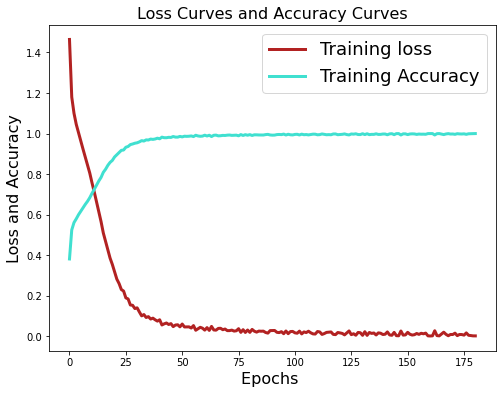

In [ ]:
#function calculates the above code in sequence
#it runs the model and also evaluates the model performance
@calc_time
def main():
  #get train,test data and labels 
  x_train, x_test, y_train, y_test, x_val, y_val, encoder = audio_features_final()
  #call the emotion recognition model
  emotion_recognition_model(x_train,y_train,x_val,y_val)
  #evaluate the model performance
  evaluate_model(x_train, x_test, y_train, y_test, x_val, y_val)

if __name__:main()

In [ ]:
x_train, x_test, y_train, y_test, x_val, y_val, encoder = audio_features_final()


labels or emotions present in dataset
 ['calm' 'sad' 'angry' 'neutral' 'happy' 'fearful' 'surprised' 'disgust'
 'fear' 'Fear' 'pleasant_surprised' 'Sad' 'Pleasant_surprise' 'anger'
 'happiness' 'sadness' 'surprise']

Unique count of labels or emotions
 fear        5769
happy       5769
angry       5769
disgust     5769
sad         5769
neutral     5109
surprise    1956
calm         576
Name: Label, dtype: int64

Unique count of labels or emotions after dropping selected labels
 fear       5769
happy      5769
angry      5769
disgust    5769
sad        5769
neutral    5109
Name: Label, dtype: int64

length of the total data is 33954

length of train data is 27163, test data is 3395 and validation set is 3396

 shape of train features and label is (27163, 178)

 shape of test features and label is (3395, 178)

 shape of validation features and label is (3396, 178)
Total time required: 1990.703 ms


In [ ]:
#mapping of the one hot ecoding with respect to their labels
print("\none hot encoding array\n",np.unique(y_train,axis=0))
print("\nOne hot encoding mapping to actual label\n",encoder.inverse_transform(np.unique(y_train,axis=0)))


one hot encoding array
 [[0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]

One hot encoding mapping to actual label
 [['sad']
 ['neutral']
 ['happy']
 ['fear']
 ['disgust']
 ['angry']]


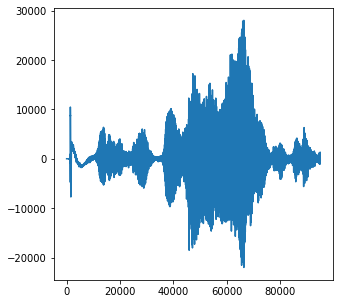


The Emotion Predicted For Recorded Audio Using Microphone is ['fear']
Total time required: 12865.033 ms


<Figure size 432x288 with 0 Axes>

In [ ]:
#this function call is used to record audio using microphone and test the model in real time on speaker voice
test_realtime(encoder)

In [ ]:
#function to check on audio sample in different language
@calc_time
def unknown_audio():
  #list for storing features, labels and datapath
  datapath = []
  X = []
  label = []
  path = '/content/drive/MyDrive/Audiofiles/realtimetested/testing on sample voices/'
  #get emotion informations
  emotions = os.listdir(path)
  #get path of emotions   
  data = [os.listdir(path+i) for i in emotions]
  for i in range(0,len(data)):
    count=0
    for j in data[i]:
      print("Number of files processed ",count)
      #librosa.load takes audio file converts to array and returns array of audio file with its sampling rate
      audio, sr = librosa.load(path+emotions[i]+'/'+j, duration=2.5, offset=0.6)
      features = get_features_recorded(audio,sr)
      for ele in features:
        X.append(ele)
        label.append(emotions[i])
        datapath.append(path+emotions[i]+'/'+j)
      count+=1
  #create a dataframe of aduio features
  Features = pd.DataFrame(X)
  #add label information 
  Features['Label'] = label
  Features['AudioPath'] = datapath
  #store the extracted features in a csv file
  Features.to_csv('/content/drive/MyDrive/Audiofiles/realtimetested/unkonwaudio.csv',index=False)  

#this is one time process to extract audio features of audio in different languages
unknown_audio()

Number of files processed  0
Number of files processed  1
Number of files processed  2
Number of files processed  3
Number of files processed  4
Number of files processed  5
Number of files processed  6
Number of files processed  7
Number of files processed  8
Number of files processed  9
Number of files processed  10
Number of files processed  11
Number of files processed  12
Number of files processed  13
Number of files processed  14
Number of files processed  15
Number of files processed  16
Number of files processed  17
Number of files processed  18
Number of files processed  19
Number of files processed  20
Number of files processed  21
Number of files processed  22
Number of files processed  23
Number of files processed  24
Number of files processed  25
Number of files processed  26
Number of files processed  27
Number of files processed  28
Number of files processed  29
Number of files processed  30
Number of files processed  31
Number of files processed  32
Number of files proc

In [ ]:
#function to find accuracy of model on different language audio
@calc_time
def diff_lang_test():
  #read different language file audio features and labels
  df = pd.read_csv('/content/drive/MyDrive/Audiofiles/realtimetested/unkonwaudio.csv')
  #load the best model
  res_model = load_model("/content/drive/MyDrive/Audiofiles/emotion-recognition.hdf5")
  #apply min max scaling
  scaler = MinMaxScaler()
  feature = scaler.fit_transform(df[df.columns[:-2]].values)
  #get the predicted label
  label=res_model.predict(feature)
  #get the label information by reversing one hot encoded output
  label_predicted=encoder.inverse_transform(label)
  #print the count of samples that match the predicted label by the model
  count=0
  for i in range(0,len(df["Label"])):
    if (df["Label"][i]).lower()==(label_predicted[i][0]).lower():
      print("original {} predicted {}".format((df["Label"][i]).lower(),(label_predicted[i][0]).lower()))
      count+=1
    else:
      pass
  print("Total count of samples to be tested for different language {}".format(len(df["Label"])))
  print("Total count of samples predicted correctly for different language {}".format(count))

diff_lang_test()

original sad predicted sad
original sad predicted sad
original sad predicted sad
original sad predicted sad
original sad predicted sad
original sad predicted sad
original sad predicted sad
original sad predicted sad
original sad predicted sad
original sad predicted sad
original sad predicted sad
original sad predicted sad
original sad predicted sad
original sad predicted sad
original sad predicted sad
original sad predicted sad
original sad predicted sad
original sad predicted sad
original sad predicted sad
original sad predicted sad
original sad predicted sad
original sad predicted sad
original sad predicted sad
original sad predicted sad
original sad predicted sad
original sad predicted sad
original sad predicted sad
original sad predicted sad
original sad predicted sad
original sad predicted sad
original sad predicted sad
original sad predicted sad
original sad predicted sad
original sad predicted sad
original sad predicted sad
original sad predicted sad
original sad predicted sad
o